## Notes

file:///home/stolpe/Downloads/CWFIS_DataServices_HowtoAccessDailyMaps&DataLayers.pdf

https://cwfis.cfs.nrcan.gc.ca/downloads/

https://cybergisxhub.cigi.illinois.edu/wp-content/uploads/2019/12/OGC_Services.html

https://cwfis.cfs.nrcan.gc.ca/background/dsm/fm3#ref

https://firesmoke.ca/resources/

http://nfdp.ccfm.org/en/data/fires.php

http://nfdp.ccfm.org/en/download.php



In [1]:
import pandas as pd
import geopandas as gpd
import geodatasets
import requests
import urllib.request
from pathlib import Path
from owslib.wfs import WebFeatureService

In [13]:
wfs = WebFeatureService("https://cwfis.cfs.nrcan.gc.ca/geoserver/wfs")
assert wfs
print(f"wfs layers: {len(wfs.contents)}")
for layerID in list(wfs.contents.keys())[:6]:
    layer = wfs[layerID]
    print('Layer ID:', layerID)
    print('Title:', layer.title)
    #print('Boundaries:', layer.boundingBoxWGS84, '\n')
    print ("BBOX:", layer.boundingBox, '\n')

wfs layers: 16
Layer ID: public:activefires_current
Title: Active Wildland Fires
BBOX: (-180.0, 30.220259209268296, 180.0, 87.46090453011479, urn:ogc:def:crs:EPSG::3978) 

Layer ID: public:fdr_current_shp
Title: Current fire danger polygon
BBOX: (-152.87909241652318, 36.1251666489418, -29.777540560554872, 74.75251594265215, urn:ogc:def:crs:EPSG::3978) 

Layer ID: public:m3_polygons_current
Title: Fire Perimeter Estimate
BBOX: (-180.0, 30.220259209268296, 180.0, 87.46090453011479, urn:ogc:def:crs:EPSG::3978) 

Layer ID: public:hotspots_last24hrs
Title: Hotspots for the last 24 hours
BBOX: (-164.1983957688663, 21.788933412939414, -44.590178766288105, 77.77977083751428, urn:ogc:def:crs:EPSG::3978) 

Layer ID: public:NFDB_point_1980to2019
Title: NFDB_point_1980to2019
BBOX: (-174.82377755752404, -6.114153240119089, 0.0, 82.82699751929074, urn:ogc:def:crs:EPSG::3978) 

Layer ID: public:nbac_2022_r12_20230630
Title: National Burned Area Composite - 2022
BBOX: (-147.16905131244528, 37.11424390

In [14]:
layer_id = 'experimental:Reported Fires'
meta = wfs.contents[layer_id]
print(meta.title)

# Get the vector data 
data = wfs.getfeature(typename=[layer_id], outputFormat='application/json')

# Save the to file
fn = 'ReportedFires.geojson'
with open(fn, 'wb') as fh:
    fh.write(data.read())



NFDB_point_1980to2019


In [2]:
geojson = gpd.read_file("./ReportedFires.geojson")

geojson

KeyboardInterrupt: 

## Data cleaning

In [85]:
provinces = gpd.read_file("georef-canada-province@public.zip")
print(provinces)

    year prov_code                    prov_name_e prov_area_c  \
0   2021    ['48']                    ['Alberta']         CAN   
1   2021    ['60']                      ['Yukon']         CAN   
2   2021    ['46']                   ['Manitoba']         CAN   
3   2021    ['10']  ['Newfoundland and Labrador']         CAN   
4   2021    ['13']              ['New Brunswick']         CAN   
5   2021    ['61']      ['Northwest Territories']         CAN   
6   2021    ['11']       ['Prince Edward Island']         CAN   
7   2021    ['47']               ['Saskatchewan']         CAN   
8   2021    ['59']           ['British Columbia']         CAN   
9   2021    ['12']                ['Nova Scotia']         CAN   
10  2021    ['62']                    ['Nunavut']         CAN   
11  2021    ['35']                    ['Ontario']         CAN   
12  2021    ['24']                     ['Quebec']         CAN   

                 prov_type                prov_name_f  \
0                 province      

In [103]:
from shapely import Point
# Remove those fires with no reported end date
excluded = len(geojson[geojson["last_rep_date"].isna()])
print(f"Excluded {excluded}/{len(geojson)} fires {excluded/len(geojson)}% due to lacking end date")

geojson = geojson[~geojson["last_rep_date"].isna()]


fires = [Point(xy) for xy in zip(geojson.lon, geojson.lat)]



Excluded 0/339652 fires 0.0% due to lacking end date


In [104]:
# Remove fires outside of provinces
province_fires = gpd.sjoin(provinces,gpd.GeoDataFrame(geojson,geometry=fires,crs=provinces.crs),how="right")
province_fires = province_fires[~province_fires["index_left"].isna()]
fires = province_fires[["prov_name_f","id","firename","startdate","hectares","agency","first_rep_date","last_rep_date","geometry"]]
fires

,prov_name_f,id,firename,startdate,hectares,agency,first_rep_date,last_rep_date,geometry
0,Québec,Reported Fires.fid-2dad970a_18e578b18cb_5821,280,2020-05-22 21:24:00+00:00,1.90,qc,2020-05-23 07:34:02+00:00,2020-05-23 11:34:06+00:00,POINT (-76.09280 46.02360)
1,Saskatchewan,Reported Fires.fid-2dad970a_18e578b18cb_5822,21DN-WHIR01,2021-04-21 06:00:00+00:00,38.00,sk,2021-04-24 09:34:04+00:00,2021-04-26 09:34:05+00:00,POINT (-108.40215 54.48630)
2,Ontario,Reported Fires.fid-2dad970a_18e578b18cb_5823,SUD_FIRE_049,2021-06-20 18:35:00+00:00,0.10,on,2021-06-20 18:34:01+00:00,2021-06-22 11:34:01+00:00,POINT (-81.20580 46.31490)
3,Colombie-Britannique,Reported Fires.fid-2dad970a_18e578b18cb_5824,2019-K50657,2019-06-18 17:47:00+00:00,0.60,bc,2019-06-24 11:43:42+00:00,2019-06-24 14:34:02+00:00,POINT (-119.64010 49.82907)
4,Québec,Reported Fires.fid-2dad970a_18e578b18cb_5825,281,2020-05-22 21:46:00+00:00,1.00,qc,2020-05-23 07:34:02+00:00,2020-05-24 09:34:01+00:00,POINT (-76.07830 45.78690)
...,...,...,...,...,...,...,...,...,...
339695,Colombie-Britannique,Reported Fires.fid-2dad970a_18e57bd5d57_-7627,2023-R21641,2023-07-13 04:43:00+00:00,0.20,bc,2023-07-15 18:34:09+00:00,2023-07-23 14:34:25+00:00,POINT (-126.65850 54.93417)
339696,Colombie-Britannique,Reported Fires.fid-2dad970a_18e57bd5d57_-7626,2023-C11499,2023-07-10 21:38:00+00:00,2970.00,bc,2023-07-16 00:34:28+00:00,2023-07-22 18:34:07+00:00,POINT (-123.71262 53.16607)
339697,Colombie-Britannique,Reported Fires.fid-2dad970a_18e57bd5d57_-7625,2023-VA1271,2023-07-08 04:02:00+00:00,0.01,bc,2023-07-15 20:34:33+00:00,2023-07-22 12:34:02+00:00,POINT (-127.03222 52.83812)
339698,Manitoba,Reported Fires.fid-2dad970a_18e57bd5d57_-7624,WE041,2023-07-11 05:00:00+00:00,1.80,mb,2023-07-16 10:34:10+00:00,2023-07-25 04:34:47+00:00,POINT (-101.27806 54.38028)


In [106]:
print(fires["agency"].unique())
print(fires["prov_name_f"].unique())

# Change unknown province shorthand
print(fires[fires["agency"] == "nrcc"]["prov_name_f"])
fires.loc[fires["agency"] == "nrcc","agency"] = "sk"
print(fires[fires["agency"] == "nrcc"]["prov_name_f"])

['qc' 'sk' 'on' 'bc' 'pc' 'ab' 'mb' 'ns' 'yt' 'nb' 'nt' 'nl' 'nrcc']
['Québec' 'Saskatchewan' 'Ontario' 'Colombie-Britannique' 'Alberta'
 'Manitoba' 'Nouvelle-Écosse' 'Yukon' 'Nunavut' 'Nouveau-Brunswick'
 'Territoires du Nord-Ouest' 'Terre-Neuve-et-Labrador']
241757    Saskatchewan
Name: prov_name_f, dtype: object
Series([], Name: prov_name_f, dtype: object)


<Axes: >

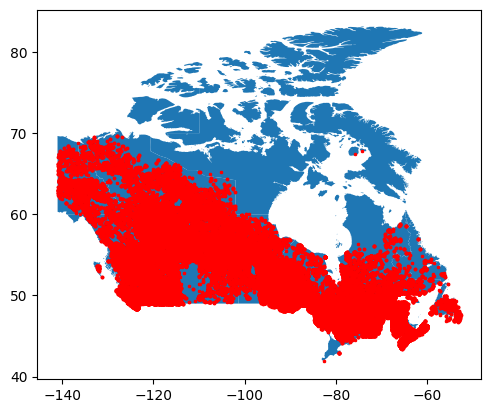

In [107]:
# Visually check distribution of fires

fires.plot(ax=provinces.plot(),color='red',marker='x',markersize=3)

In [112]:
# Transform dates to day-grain
fires["startdate"]= fires["startdate"].apply(lambda t: t.date())
fires["first_rep_date"]= fires["first_rep_date"].apply(lambda t: t.date())
fires["last_rep_date"]= fires["last_rep_date"].apply(lambda t: t.date())
fires

/home/stolpe/Documents/uottawa/DS/Data-Science-Term-Project/ds-project/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/stolpe/Documents/uottawa/DS/Data-Science-Term-Project/ds-project/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/stolpe/Documents/uottawa/DS/Data-Science-Term-Project/ds-project/lib/python3.11/site-p

,prov_name_f,id,firename,startdate,hectares,agency,first_rep_date,last_rep_date,geometry
0,Québec,Reported Fires.fid-2dad970a_18e578b18cb_5821,280,2020-05-22,1.90,qc,2020-05-23,2020-05-23,POINT (-76.09280 46.02360)
1,Saskatchewan,Reported Fires.fid-2dad970a_18e578b18cb_5822,21DN-WHIR01,2021-04-21,38.00,sk,2021-04-24,2021-04-26,POINT (-108.40215 54.48630)
2,Ontario,Reported Fires.fid-2dad970a_18e578b18cb_5823,SUD_FIRE_049,2021-06-20,0.10,on,2021-06-20,2021-06-22,POINT (-81.20580 46.31490)
3,Colombie-Britannique,Reported Fires.fid-2dad970a_18e578b18cb_5824,2019-K50657,2019-06-18,0.60,bc,2019-06-24,2019-06-24,POINT (-119.64010 49.82907)
4,Québec,Reported Fires.fid-2dad970a_18e578b18cb_5825,281,2020-05-22,1.00,qc,2020-05-23,2020-05-24,POINT (-76.07830 45.78690)
...,...,...,...,...,...,...,...,...,...
339695,Colombie-Britannique,Reported Fires.fid-2dad970a_18e57bd5d57_-7627,2023-R21641,2023-07-13,0.20,bc,2023-07-15,2023-07-23,POINT (-126.65850 54.93417)
339696,Colombie-Britannique,Reported Fires.fid-2dad970a_18e57bd5d57_-7626,2023-C11499,2023-07-10,2970.00,bc,2023-07-16,2023-07-22,POINT (-123.71262 53.16607)
339697,Colombie-Britannique,Reported Fires.fid-2dad970a_18e57bd5d57_-7625,2023-VA1271,2023-07-08,0.01,bc,2023-07-15,2023-07-22,POINT (-127.03222 52.83812)
339698,Manitoba,Reported Fires.fid-2dad970a_18e57bd5d57_-7624,WE041,2023-07-11,1.80,mb,2023-07-16,2023-07-25,POINT (-101.27806 54.38028)


In [151]:
import numpy as np
from tqdm import tqdm
# Split fires into per day hectares burnt
rows = []
for row in tqdm(fires.itertuples(),total=len(fires)):
    start = row.startdate if not pd.isnull(row.startdate) else row.first_rep_date
    end = row.last_rep_date if not pd.isnull(row.last_rep_date) else row.startdate 
    days = pd.date_range(start=start,end=end)
    avg_burnt = row.hectares/max(len(days),1.0)
    for day in days:
        row_copy = row._asdict()
        row_copy["hectares"] = avg_burnt
        row_copy["day"] = day
        rows.append(row_copy)
fires_daily = gpd.GeoDataFrame(rows,crs=fires.crs)
fires_daily

 24%|██▎       | 69323/293436 [01:32<21:10, 176.41it/s]  

: 

: 

## Split up fires on a per day basis

